<center>
<h2> <strong>Graphs in Machine Learning</strong> Assignment 2: <strong> Semi-Supervised Learning (SSL)</strong></h2>
<hr>
<strong> Ben KABONGO B. </strong><br/>
M2 MVA, ENS Paris-Saclay<br/>
<i>ben.kabongo_buzangu@ens-paris-saclay.fr</i>
<hr>
</center>

SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = None

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'unn'

# Coefficients for C matrix for soft HFS
params['c_l'] = None
params['c_u'] = None

In [2]:
def compute_hfs(L, Y, soft=False, **params):
    """
    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    l_idx = np.where(Y != 0)[0]
    u_idx = np.where(Y == 0)[0]
    y = OneHotEncoder().fit_transform(Y.reshape(-1, 1)).toarray()[:, 1:]

    if not soft:    
        """
        Compute hard HFS.  

        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        f_l = y[l_idx]
        L_uu = L[u_idx][:, u_idx]
        L_ul = L[u_idx][:, l_idx]
        f_u = - (np.linalg.pinv(L_uu)).dot(L_ul.dot(f_l))
        f = np.zeros_like(y)
        f[l_idx] = f_l
        f[u_idx] = f_u

    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        c_l, c_u = params["c_l"], params["c_u"]
        C = np.zeros(num_samples)
        C[l_idx] = c_l
        C[u_idx] = c_u
        C = np.diag(C)
        f = np.linalg.pinv(((np.linalg.pinv(C)).dot(L) + np.identity(num_samples))).dot(y)

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    labels = 1 + f.argmax(axis=1)
    return labels, f


In [9]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', 
                plot=True, per_class=False, seed=None, **params):
    """    
    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l, per_class=per_class)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'], 
    # params['k'] and params['laplacian_normalization'].
    
    L = build_laplacian_regularized(
        X, 
        laplacian_regularization=params["laplacian_regularization"], 
        var=params["var"], 
        eps=params["eps"], 
        k=params["k"], 
        laplacian_normalization=params["laplacian_normalization"]
    )

    labels, f = compute_hfs(L, Y_masked, soft, **params)

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == np.squeeze(Y))
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

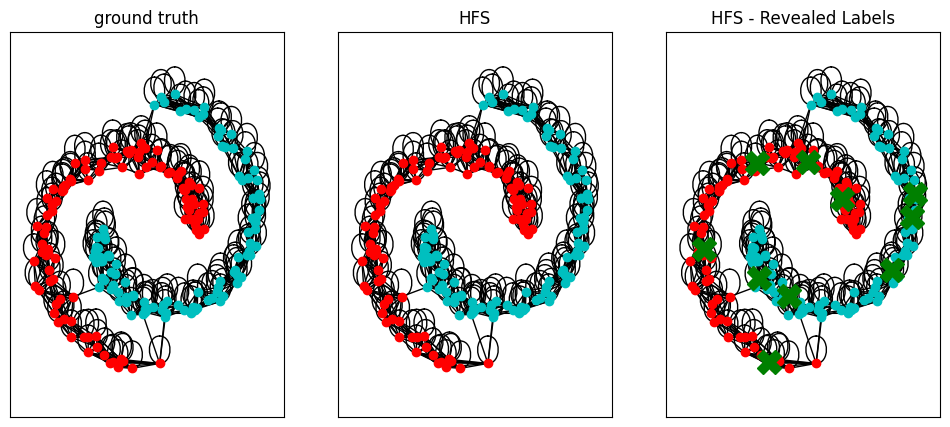

Soft=False, Accuracy=1.0


In [5]:
seed = 42
params = {
    'laplacian_regularization': 0.0,
    'var': 1.0,
    'eps': None,
    'k': 10,
    'laplacian_normalization': 'unn',
    'c_l': 0.99,
    'c_u': 0.01,
}
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=False, dataset='data_2moons_hfs.mat',
                                                 plot=True, seed=seed, **params)

> We achieve 100% accuracy. We can therefore conclude that the HFS algorithm can correctly label unlabeled examples. 

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

In [10]:
np.random.seed(42)
accuracies = []
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, 
                                                    dataset='data_2moons_hfs_large.mat',
                                                    plot=False, per_class=True, seed=None, **params)
    accuracies.append(hard_accuracy)

Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0


> We note that running the HFS algorithm on a large dataset for which very few labeled examples are selected (here 4) can sometimes raise an exception, due to the insufficient number of examples which sometimes select only a single class for learning. 

> To avoid this exception, we can use the `per_class` parameter of the `mask_labels` function, which selects an equal number of examples labeled by class. In this way, we can easily execute the algorithm.

> The resulting accuracy is 100% for all runs. This further confirms the efficiency of the HFS algorithm.

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

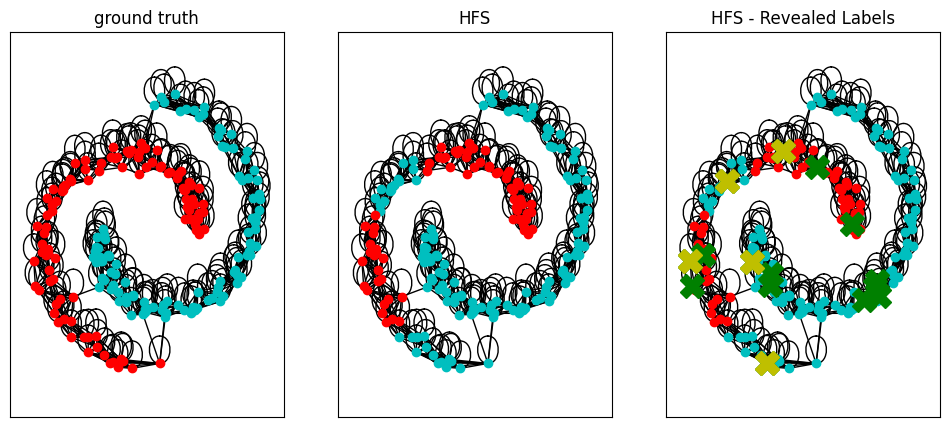

Soft=False, Accuracy=0.855


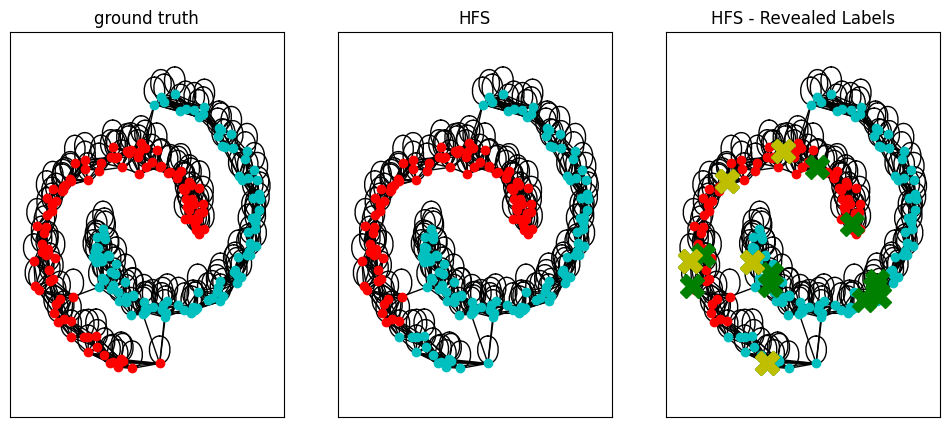

Soft=True, Accuracy=0.93
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.93
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.93
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.93
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.93
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.93
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.93
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.93
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.93
Soft=False, Accuracy=0.855
Soft=True, Accuracy=0.93

Hard: mean = 0.8550 std = 0.0000
Soft: mean = 0.9300 std = 0.0000


In [15]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

hard_accuracies = []
soft_accuracies = []

for ii in range(10):
    plot = (ii == 0)
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                    plot=plot, seed=seed, **params)
    X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                    plot=plot, seed=seed, **params)
    hard_accuracies.append(hard_accuracy)
    soft_accuracies.append(soft_accuracy)

print()
print(f"Hard: mean = {np.mean(hard_accuracies):.4f} std = {np.std(hard_accuracies):.4f}")
print(f"Soft: mean = {np.mean(soft_accuracies):.4f} std = {np.std(soft_accuracies):.4f}")

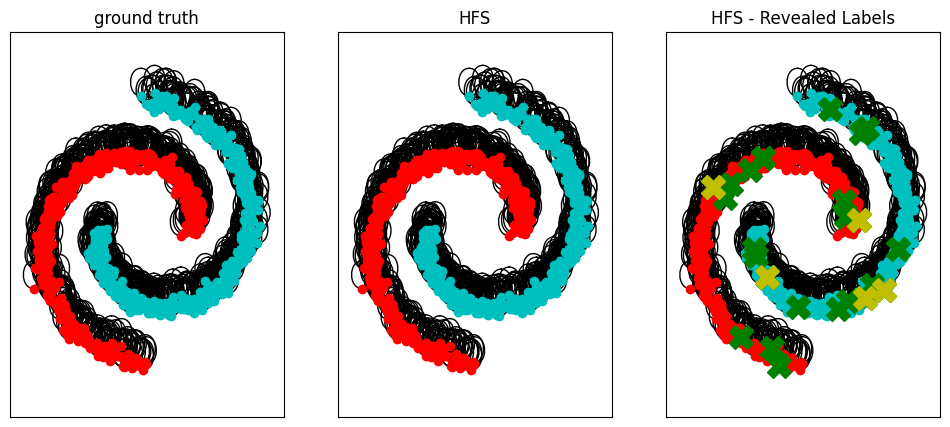

Soft=False, Accuracy=1.0


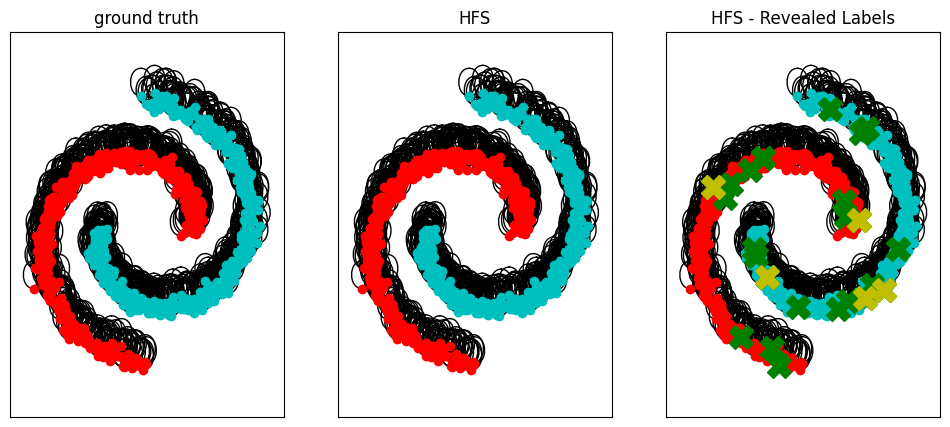

Soft=True, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=True, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=True, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=True, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=True, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=True, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=True, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=True, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=True, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=True, Accuracy=1.0

Hard: mean = 1.0000 std = 0.0000
Soft: mean = 1.0000 std = 0.0000


In [17]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs_large.mat'

hard_accuracies = []
soft_accuracies = []

for ii in range(10):
    plot = (ii == 0)
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                    plot=plot, per_class=True, seed=seed, **params)
    X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                    plot=plot, per_class=True, seed=seed, **params)
    hard_accuracies.append(hard_accuracy)
    soft_accuracies.append(soft_accuracy)

print()
print(f"Hard: mean = {np.mean(hard_accuracies):.4f} std = {np.std(hard_accuracies):.4f}")
print(f"Soft: mean = {np.mean(soft_accuracies):.4f} std = {np.std(soft_accuracies):.4f}")

> Both versions of the algorithm (hard and soft) achieve accuracy above 85%. This further confirms the effectiveness of HFS, in both its hard and soft versions.

> On average, however, the soft version achieves better accuracy than the hard version. This is because, in a configuration with noisy labels, the hard version performs less well, as it doesn't take these labels into account correctly.

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

> In cases where we have more than two classes, we use one-hot encoding for the classes. One-hot encoding consists in transforming the target vector of size `num_samples` into a binary matrix of size `num_samples x num_classes`, where for each example the column corresponding to its class is set to 1 and the rest to 0, with `num_samples` the number of examples and `num_classes` the number of classes. For unlabeled examples, all classes are 0 in the one-hot encoding matrix.

> Initially, we have the vector of labels $y \in \mathbf{R}^N$, with the one-hot encoding, we obtain the matrix $Y \in \mathbf{R}^{N \times C}$.
Then, when running the HFS algorithm, $f$ is no longer represented by a vector in $\mathbf{R}^N$ but by a matrix in $\mathbf{R}^{N \times C}$, which gives the probability of belonging to each class for each example.
Finally, to find the labels of the examples, we take for each example the class with the highest value.

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 

> We compared two different preprocessings, namely the default preprocessing (with bilateralFilter + equalizeHist + GaussianBlur) and a second preprocessing (with bilateralFilter + createCLAHE + medianBlur).

> For both preprocessings, we perform a grid search by varying some parameters of the HFS algorithm to find the combination of parameters that maximizes accuracy. We can see that the second preprocessing gives better accuracy for data with 10 images per person and for data with 50 images per person. For the first dataset, the best accuracy obtained with the default preprocessing is `82%`, while it is `86%` with the second preprocessing. On the augmented dataset, it is `67%` for the default preprocessing and over `70%` for the second preprocessing.


* Best accuracy:
    * `10 images per person`: `86%`
    * `50 image per person`: `70.4%`

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

> The change in accuracy when using the augmented dataset can be attributed to several factors. While the traditional belief is that using additional data always leads to improved performance, in practice, there are nuances to consider.

> The increase in the number of images per person from 10 to 50 in the augmented dataset might not necessarily guarantee improved accuracy. The effectiveness of additional data depends on various factors such as data quality, diversity, and relevance to the task. In some cases, augmenting the dataset may introduce noise or irrelevant variations, leading to a decrease in accuracy.

> In the context of semi-supervised learning with HFS (Hierarchical Feature Selection), it's crucial to evaluate how well the algorithm generalizes to new data. The grid search for optimal parameters in each run might also contribute to variations in performance. Additionally, the impact of different executions of HFS on the semi-supervised learning process should be taken into account.

In [3]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [4]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 1.0
params_face_rec['var'] = 10000.0
params_face_rec['eps'] = None
params_face_rec['k'] = None
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = None
params_face_rec['c_u'] = None

In [5]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(float)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

In [6]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image_2(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image,3, 75,75)
    clahe = cv2.createCLAHE(tileGridSize=(8,8))
    image = clahe.apply(image)
    image = cv2.medianBlur(image,3)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(float)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

In [7]:
def grid_search(images, masked_labels, labels, params):
    best_accuracy = 0.0
    best_params = {}

    params_face_rec = {}
    params_face_rec["eps"] = None

    for laplacian_regularization in params["laplacian_regularization"]:
        params_face_rec["laplacian_regularization"] = laplacian_regularization

        for laplacian_normalization in params["laplacian_normalization"]:
            params_face_rec["laplacian_normalization"] = laplacian_normalization

            for k in params["k"]:
                params_face_rec["k"] = k

                for var in params["var"]:
                    params_face_rec["var"] = var

                    for c_l in params["c_l"]:
                        params_face_rec["c_l"] = c_l
                        params_face_rec["c_u"] = 1 - c_l

                        L = build_laplacian_regularized(
                            images, 
                            params_face_rec['laplacian_regularization'], 
                            params_face_rec['var'], 
                            params_face_rec['eps'], 
                            params_face_rec['k'], 
                            params_face_rec['laplacian_normalization']
                        )
                        predicted_labels, _ = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
                        accuracy = np.equal(predicted_labels, labels).mean()
                        #print(str(params_face_rec), ":", accuracy)

                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_params = dict(params_face_rec)

    return best_params, best_accuracy

#### 10 images per person - default preprocessing

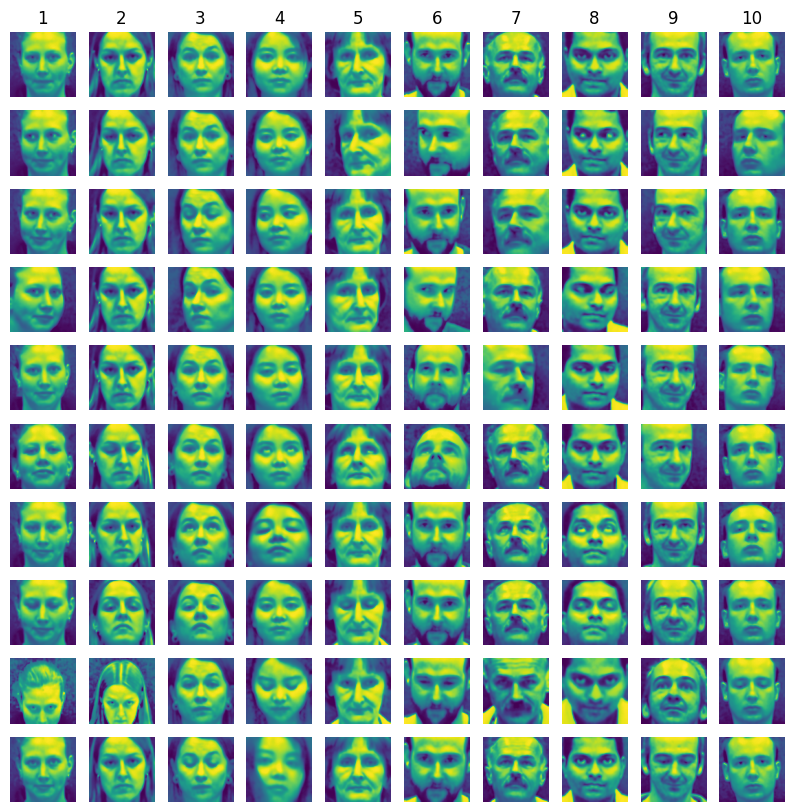

(100, 9216)
[[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.]
 [ 1.  2.  0.  4.  0.  0.  7.  0.  0.  0.]
 [ 1.  0.  3.  0.  0.  0.  0.  0.  9.  0.]
 [ 1.  0.  3.  0.  0.  6.  0.  0.  9. 10.]
 [ 0.  0.  0.  4.  5.  6.  0.  8.  0.  0.]
 [ 0.  0.  0.  4.  5.  0.  0.  0.  0.  0.]
 [ 0.  2.  3.  0.  0.  0.  0.  0.  9. 10.]
 [ 0.  0.  0.  0.  5.  6.  7.  0.  0. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  8.  9. 10.]
 [ 0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]]


In [24]:
# 10 images per person
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)

# Uncomment below if you want to visualize the images
plot_image_data(images)
print(images.shape)
print(masked_labels.reshape(-1, 10))

In [67]:
params_face_rec = {
    'laplacian_regularization': 0.05,
    'var': 1000_000.0,
    'eps': None,
    'k': 4,
    'laplacian_normalization': 'rw',
    'c_l': 0.99,
    'c_u': 0.01
}

In [68]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

In [69]:
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)

print(masked_labels)
print(predicted_labels)
print(labels)

Accuracy =  0.8
[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.  1.  2.  0.  4.  0.  0.  7.  0.
  0.  0.  1.  0.  3.  0.  0.  0.  0.  0.  9.  0.  1.  0.  3.  0.  0.  6.
  0.  0.  9. 10.  0.  0.  0.  4.  5.  6.  0.  8.  0.  0.  0.  0.  0.  4.
  5.  0.  0.  0.  0.  0.  0.  2.  3.  0.  0.  0.  0.  0.  9. 10.  0.  0.
  0.  0.  5.  6.  7.  0.  0. 10.  0.  0.  0.  0.  5.  0.  0.  8.  9. 10.
  0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  3  9  7  8  1  9  1  2  3  3
  5  6  9  8  9 10  1  2  3  4  5  6 10  8  9 10  1  2  3  4  5  6 10  8
 10 10 10  2  4  4  5  4  7  8  6 10  1  2  3 10  5  6  7  4  9 10  1  2
 10  4  5  6  7 10  9 10  4  4  3  4  5  6  8  8  9 10  1  2  3  4  5  6
  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8
  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2
  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 

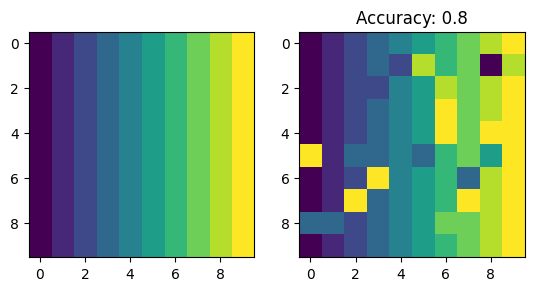

In [70]:
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

In [ ]:
params = {
    "laplacian_regularization": [0.1, 0.4, 0.7, 1.0],
    "laplacian_normalization": ["unn", "sym", "rw"],
    "k": [4, 5, 6, 7, 8, 9],
    "var": [1_000, 10_000, 100_000, 1_000_000],
    "c_l": [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
}
best_params, best_accuracy = grid_search(images, masked_labels, labels, params)

In [93]:
print(best_params, ":", best_accuracy)

{'eps': None, 'laplacian_regularization': 0.1, 'laplacian_normalization': 'unn', 'k': 4, 'var': 1000, 'c_l': 0.9, 'c_u': 0.09999999999999998} : 0.82


Accuracy =  0.82


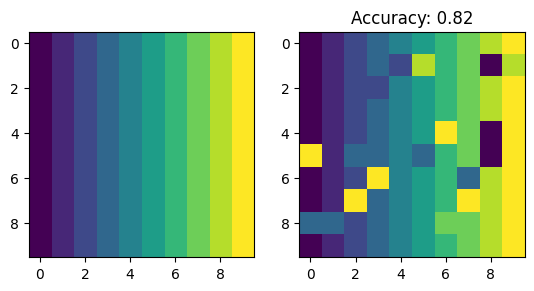

In [94]:
params_face_rec = best_params
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)

plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

#### 10 images per person - preprocessing 2

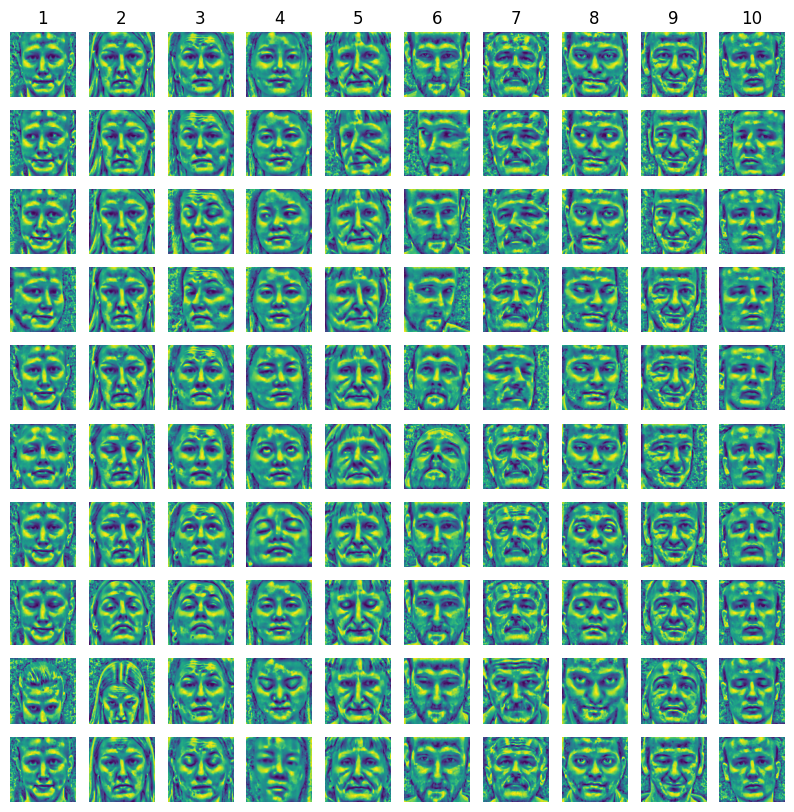

In [101]:
# 10 images per person
np.random.seed(456)   # set seed, since labels are masked randomly
images_2, labels_2, masked_labels_2 = load_image_data(preprocess_image_2)

# Uncomment below if you want to visualize the images
plot_image_data(images_2)

Accuracy =  0.86


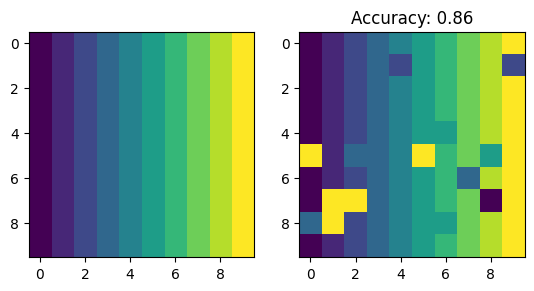

In [102]:
L = build_laplacian_regularized(images_2, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

predicted_labels_2, f = compute_hfs(L, masked_labels_2, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels_2, labels_2).mean()
print("Accuracy = ", accuracy)

plt.subplot(121)
plt.imshow(labels_2.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_2.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

#### 50 images per person - default preprocessing

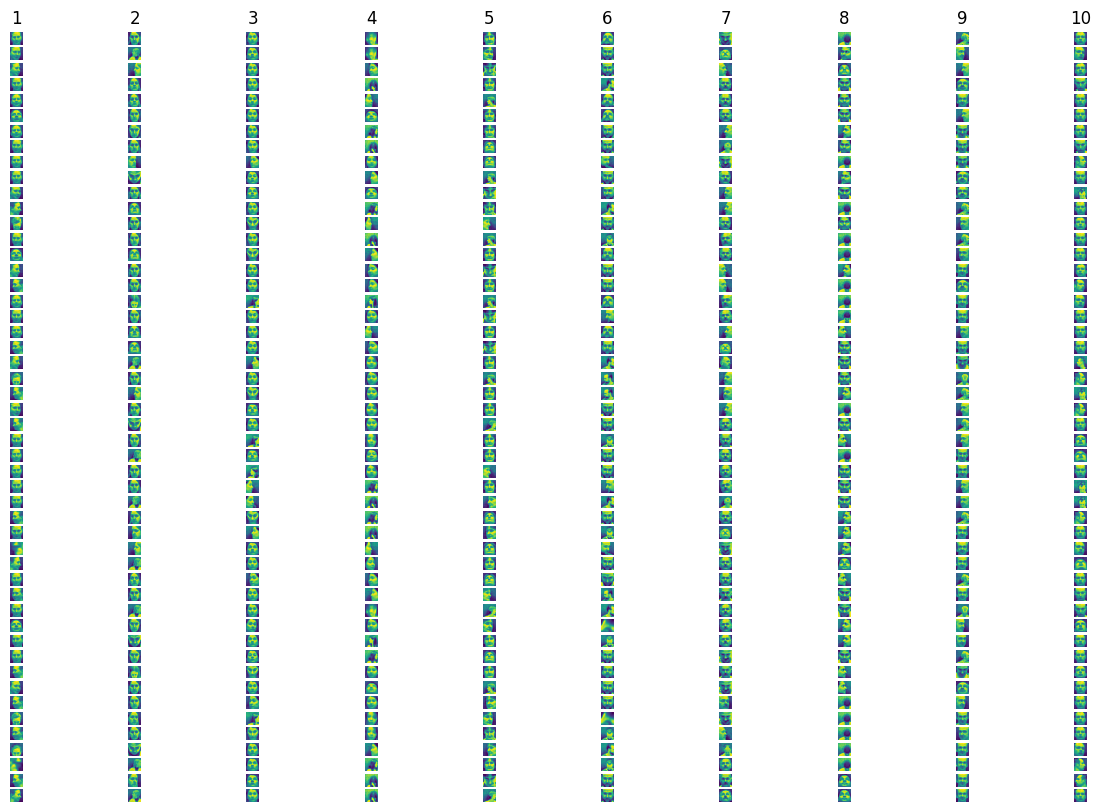

In [72]:
# 50 images per person
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
plot_image_data_augmented(images_a)

In [83]:
params_face_rec = {
    'laplacian_regularization': 0.05,
    'var': 1000.0,
    'eps': None,
    'k': 10,
    'laplacian_normalization': 'unn',
    'c_l': 0.95,
    'c_u': 0.05
}

L = build_laplacian_regularized(images_a, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

Accuracy =  0.536


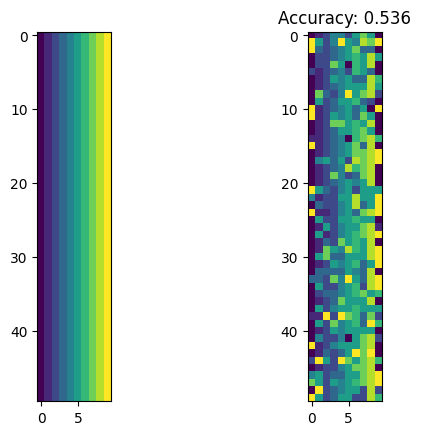

In [84]:
# Run HFS
predicted_labels_a, f = compute_hfs(L, masked_labels_a, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels_a, labels_a).mean()
print("Accuracy = ", accuracy)

plt.subplot(121)
plt.imshow(labels_a.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_a.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

#### 50 images per person - preprocessing 2

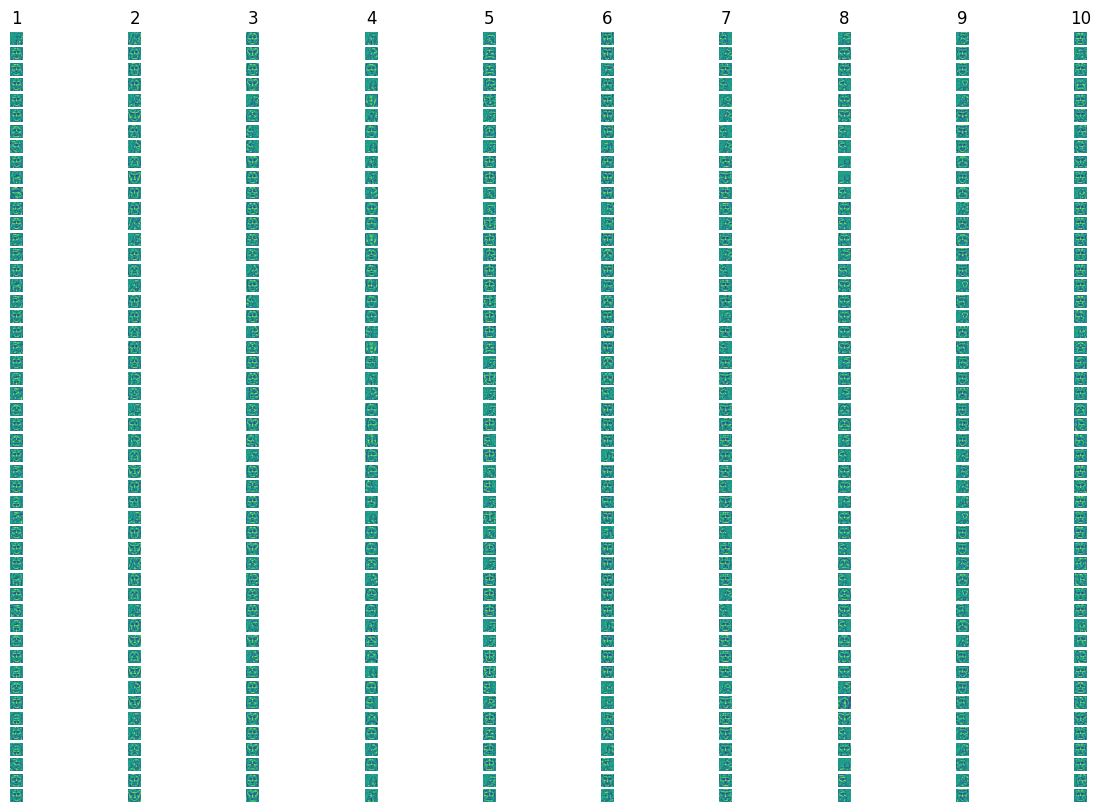

In [105]:
# 50 images per person
images_a2, labels_a2, masked_labels_a2 = load_image_data_augmented(preprocess_image_2)
plot_image_data_augmented(images_a2)

Accuracy =  0.688


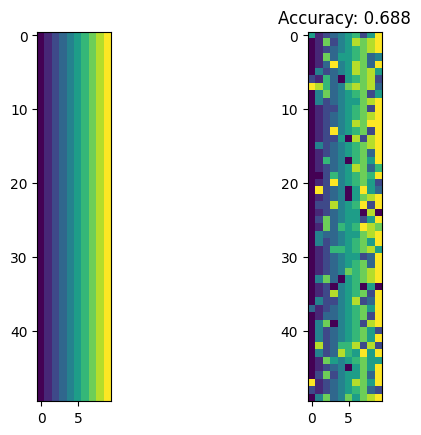

In [106]:
params_face_rec = {
    'laplacian_regularization': 0.05,
    'var': 1000.0,
    'eps': None,
    'k': 10,
    'laplacian_normalization': 'unn',
    'c_l': 0.95,
    'c_u': 0.05
}

L = build_laplacian_regularized(images_a2, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels_a2, f = compute_hfs(L, masked_labels_a2, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels_a2, labels_a2).mean()
print("Accuracy = ", accuracy)

plt.subplot(121)
plt.imshow(labels_a2.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_a2.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

In [ ]:
params_a = {
    "laplacian_regularization": [0.1, 0.4, 0.7, 1.0],
    "laplacian_normalization": ["unn", "sym", "rw"],
    "k": [5, 10, 15, 20, 25, 30, 40, 45],
    "var": [1_000, 10_000, 100_000, 1_000_000],
    "c_l": [0.75, 0.8, 0.9, 0.95, 0.99],
}
best_params_a, best_accuracy_a = grid_search(images_a2, masked_labels_a2, labels_a2, params_a)

In [108]:
print(best_params_a, ":", best_accuracy_a)

{'eps': None, 'laplacian_regularization': 0.4, 'laplacian_normalization': 'unn', 'k': 5, 'var': 100000, 'c_l': 0.95, 'c_u': 0.050000000000000044} : 0.704


Accuracy =  0.704


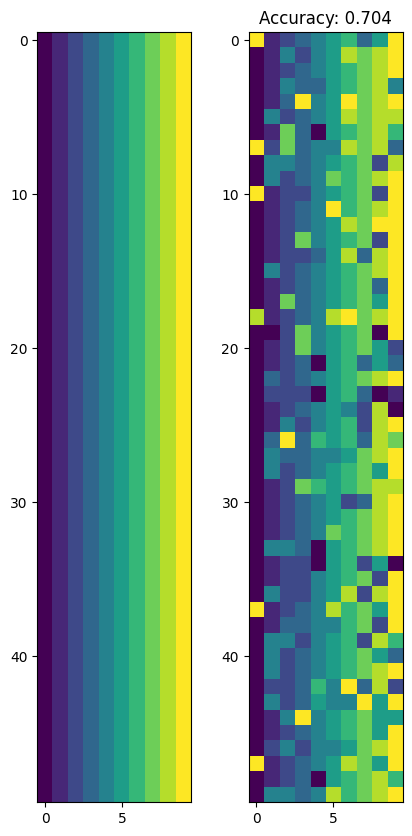

In [112]:
params_face_rec = best_params_a
L = build_laplacian_regularized(images_a2, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels_a2, f = compute_hfs(L, masked_labels_a2, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels_a2, labels_a2).mean()
print("Accuracy = ", accuracy)

plt.figure(figsize=(5, 10))
plt.subplot(121)
plt.imshow(labels_a2.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_a2.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`
    
### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition

In [9]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 1.0
params_online_ssl['var'] = 10000.0
params_online_ssl['eps'] = None
params_online_ssl['k'] = None
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = None
params_online_ssl['c_u'] = None

In [10]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
    
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])


    def online_ssl_update_centroids(self, face):
        """
        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
            n_centroids = self.centroids_distances.shape[0]
            argsort = self.centroids_distances.flatten().argsort()
            for idx in argsort:
                c_1 = idx // n_centroids
                c_2 = idx // n_centroids
                if not c_1 in self.taboo or not c_2 in self.taboo:
                    break

            c_rep, c_add = None, None
            if c_1 in self.taboo:
                c_rep = c_1
                c_add = c_2
            elif c_2 in self.taboo:
                c_rep = c_2
                c_add = c_1
            elif self.V[c_2] <= self.V[c_1]:
                c_rep = c_1
                c_add = c_2
            else:
                c_rep = c_2
                c_add = c_1 

            """
            Update data structures: self.centroids and self.V
            """
            self.V[c_rep] = self.V[c_rep] + self.V[c_add]
            self.centroids[c_add] = face
            self.V[c_add] = 1

            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        
        W_ = build_similarity_graph(
            self.centroids, 
            var=params_online_ssl["var"], 
            k=params_online_ssl["k"], 
            eps=params_online_ssl["eps"]
        )
        W = V.dot(W_).dot(V)
        L = build_laplacian(W, params_online_ssl["laplacian_normalization"])
        Q = L + params_online_ssl["laplacian_regularization"] * np.identity(L.shape[0])

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1 
        label_scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
        
            # handle unknown faces
            if f[self.last_face].max() < 0.8:
                label = "FeshFace"
            
            label_scores.append((label, score))

        return label_scores
      


In [ ]:
create_user_profile('Ben Kabongo')

In [ ]:
create_user_profile('Yann LeCun')

In [6]:
params_online_ssl['k'] = 15
params_online_ssl['laplacian_regularization'] = 0.05
online_face_recognition(['Ben Kabongo', 'Yann LeCun'], IncrementalKCenters, n_pictures=15)

Profile found with 57 images.
Profile found with 85 images.


### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification

> Initially, we will store all identified unknown faces, along with their indices, in designated lists. If the count of unknown faces surpasses the predefined optimal appearance threshold (set at 15 pictures in this instance), we will proceed to verify whether the most recently detected face has been encountered a sufficient number of times. Put differently, we will assess if the count of faces with the closest distance to it exceeds the optimal appearance number. In such instances, we will introduce a new label, "FreshFace," to the label list. Subsequently, we will reassign all classes marked as '0' for these faces to a novel class, which corresponds to max(classes)+1. Finally, we will eliminate these faces from the list of unknown faces and their respective indices. The algorithm will then showcase the new class upon the detection of a subsequently identified face.

### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn import metrics, svm, linear_model, model_selection, semi_supervised

* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces

> We start by modifying the face image loading function, allowing you to select the number of different people and vary the number of masked labels per person. For the comparison between a supervised and a semi-supervised algorithm, we load a dataset with 3 classes (people), and for each class we retain 30 images and mask 20. This gives a labeled dataset of 90 examples and an unlabeled dataset of 60 examples.

> We choose convolutional neural networks for the supervised algorithm and HFS for the semi-supervised algorithm. We train the supervised model on labeled data and evaluate it on unlabeled data. For HFS, we search for the best parameters using grid search.

> For our particular case, with 90 labeled images and 60 unlabeled images, HFS has an accuracy of 97.34%, while the convolutional model has an accuracy of 100%. However, for a very small number of labeled images or a very large number of labels, HFS can be more efficient than the convolutional model.

In [12]:
from load_images import NB_IMGS_AUGMENTED, FRAME_SIZE

def load_image_data_augmented_2(
        preprocess_fn=preprocess_image_2,
        num_persons=10,
        unmasked_per_person=4,
    ):
    # Parameters
    cc = cv2.CascadeClassifier(os.path.join('data', 'haarcascade_frontalface_default.xml'))
    # Loading images
    images = np.zeros((num_persons * NB_IMGS_AUGMENTED, FRAME_SIZE ** 2))
    labels = np.zeros(num_persons * NB_IMGS_AUGMENTED, dtype=np.uint32)

    for i in np.arange(num_persons):
        imgdir = "data/extended_dataset/%d" % i
        imgfns = os.listdir(imgdir)
        for j, imgfn in enumerate(np.random.choice(imgfns, size=NB_IMGS_AUGMENTED)):
            im = imread("{}/{}".format(imgdir, imgfn))
            box = cc.detectMultiScale(im)
            top_face = {"area": 0, "box": (0, 0, *im.shape[:2])}

            for cfx, cfy, clx, cly in box:
                face_area = clx * cly
                if face_area > top_face["area"]:
                    top_face["area"] = face_area
                    top_face["box"] = [cfx, cfy, clx, cly]

            fx, fy, lx, ly = top_face["box"]
            gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            gray_face = gray_im[fy:fy + ly, fx:fx + lx]

            """
            Apply preprocessing to balance the image (color/lightning), such as filtering 
            (cv.boxFilter, cv.GaussianBlur, cv.bilinearFilter) and
            equalization (cv.equalizeHist).   
            """
            gray_face = preprocess_fn(gray_face)

            # resize the face and reshape it to a row vector, record labels
            images[j * num_persons + i] = gray_face.reshape((-1))
            labels[j * num_persons + i] = i + 1

    """
    select 4 random labels per person and reveal them  
    masked_labels: (n x 1) masked label vector, where entries Y_i take a values in [1, ..., num_classes] if the node is  
              labeled, or 0 if the node is unlabeled (masked)   
    """
    masked_labels = mask_labels(labels, unmasked_per_person, per_class=True)

    return images, labels, masked_labels

In [53]:
num_persons = 3
images_a2, labels_a2, masked_labels_a2 = load_image_data_augmented_2(
    preprocess_image_2, num_persons=num_persons, unmasked_per_person=30
)

In [54]:
params_a = {
    "laplacian_regularization": [0.1, 0.4, 0.7, 1.0],
    "laplacian_normalization": ["unn", "sym", "rw"],
    "k": [5, 10, 15, 20, 25, 30, 40, 45],
    "var": [1_000, 10_000, 100_000, 1_000_000],
    "c_l": [0.75, 0.8, 0.9, 0.95, 0.99],
}
best_params_a, best_accuracy_a = grid_search(images_a2, masked_labels_a2, labels_a2, params_a)
print(best_params_a, ":", best_accuracy_a)

{'eps': None, 'laplacian_regularization': 0.1, 'laplacian_normalization': 'unn', 'k': 5, 'var': 1000, 'c_l': 0.75, 'c_u': 0.25} : 0.9733333333333334


Accuracy =  0.9733333333333334


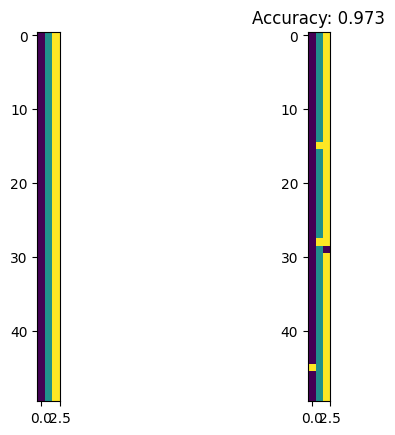

In [59]:
params_face_rec = best_params_a
L = build_laplacian_regularized(images_a2, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels_a2, f = compute_hfs(L, masked_labels_a2, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels_a2, labels_a2).mean()
print("Accuracy = ", accuracy)

plt.figure()
plt.subplot(121)
plt.imshow(labels_a2.reshape((-1, num_persons)))
plt.subplot(122)
plt.imshow(predicted_labels_a2.reshape((-1, num_persons)))
plt.title(f"Accuracy: {accuracy:.3f}")
plt.show()

In [37]:
def test(model, loss_fn, dataloader, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = torch.FloatTensor(X).to(device)
            y = torch.LongTensor(y).to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    accuracy /= size
    return test_loss, accuracy


def train(model, optimizer, loss_fn, dataloader, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, accuracy = 0, 0
    for X, y in dataloader:
        X = torch.FloatTensor(X).to(device)
        y = torch.LongTensor(y).to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss /= num_batches
    accuracy /= size
    return train_loss, accuracy


def trainer(model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs, device=None):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    progress_bar = tqdm(range(1, n_epochs + 1))
    for epoch in progress_bar:
        train_loss, train_accuracy = train(model, optimizer, loss_fn, train_dataloader, device)
        test_loss, test_accuracy = test(model, loss_fn, test_dataloader, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        progress_bar.set_description(f"[Epoch {epoch} / {n_epochs}] train loss = {train_loss:.2f} acc = {train_accuracy:.2f} " +
            f"test loss = {test_loss:.2f} acc = {test_accuracy:.2f}")

    return (train_losses, train_accuracies), (test_losses, test_accuracies)

In [11]:
class FaceDataset(Dataset):

    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

In [47]:
batch_size = 40
images_a2 = images_a2.reshape(-1, 1, 96, 96).astype(np.float32)
labels_a2 = labels_a2.reshape(-1).astype(int)
X_labeled = images_a2[masked_labels_a2 != 0]
y_labeled = labels_a2[masked_labels_a2 != 0] - 1
X_unlabeled = images_a2[masked_labels_a2 == 0]
y_unlabeled = labels_a2[masked_labels_a2 == 0] - 1
labeled_dataset = FaceDataset(X_labeled, y_labeled)
unlabeled_dataset = FaceDataset(X_unlabeled, y_unlabeled)
labeled_dataloader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)

In [48]:
print(X_labeled.shape, y_labeled.shape, X_unlabeled.shape, y_unlabeled.shape)

(90, 1, 96, 96) (90,) (60, 1, 96, 96) (60,)


In [49]:
class FaceCNN(nn.Module):

    def __init__(self, num_classes=10):
        super(FaceCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(36864, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [50]:
model = FaceCNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 100

(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, labeled_dataloader, unlabeled_dataloader, n_epochs, device
)

[Epoch 100 / 100] train loss = 0.00 acc = 1.00 test loss = 0.01 acc = 1.00: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


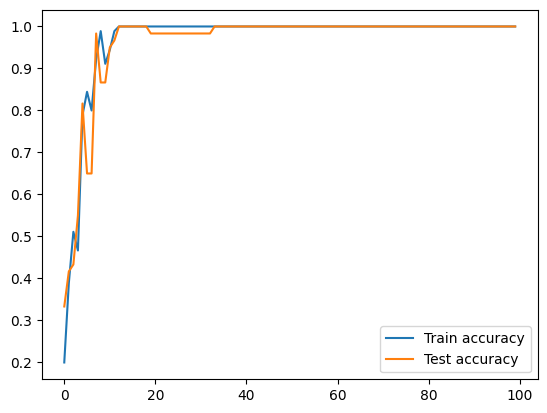

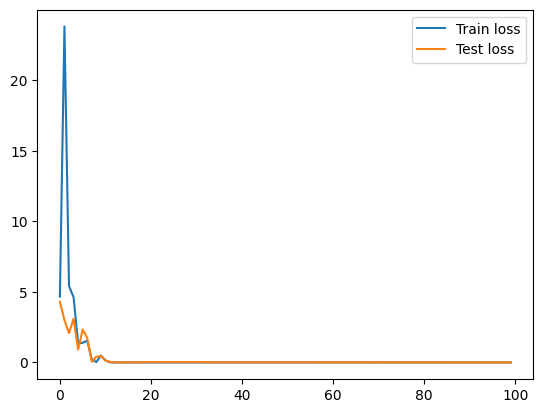

In [51]:
plt.figure()
plt.plot(train_accuracies, label="Train accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.

> Here we compare SVM and HFS on 100 images with 2 labels. The SVM model is trained and evaluated on the entire data set. The final accuracy of the SVM model is 100%, that of HFS is 99%.

In [61]:
num_persons = 2
images_a2, labels_a2, masked_labels_a2 = load_image_data_augmented_2(
    preprocess_image_2, num_persons=num_persons, unmasked_per_person=30
)

In [62]:
params_a = {
    "laplacian_regularization": [0.1, 0.4, 0.7, 1.0],
    "laplacian_normalization": ["unn", "sym", "rw"],
    "k": [5, 10, 15, 20, 25, 30, 40, 45],
    "var": [1_000, 10_000, 100_000, 1_000_000],
    "c_l": [0.75, 0.8, 0.9, 0.95, 0.99],
}
best_params_a, best_accuracy_a = grid_search(images_a2, masked_labels_a2, labels_a2, params_a)
print(best_params_a, ":", best_accuracy_a)

{'eps': None, 'laplacian_regularization': 0.1, 'laplacian_normalization': 'unn', 'k': 5, 'var': 1000, 'c_l': 0.75, 'c_u': 0.25} : 0.99


In [63]:
images_a2 = images_a2.reshape(-1, 96 * 96).astype(np.float32)
labels_a2 = labels_a2.reshape(-1).astype(int) - 1

In [64]:
svm_model = svm.SVC()
svm_model.fit(images_a2, labels_a2)
accuracy = metrics.accuracy_score(svm_model.predict(images_a2), labels_a2)
print("Accuracy :", accuracy)

Accuracy : 1.0


* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.

> Here we compare SVM and LabelSpreading on 100 images with 2 labels. We report below the accuracy of each model in differents cases. SVM outperforms LabelSpreading on unseen data.

* Supervised (SVM):
	* Seen data: 0.9875
	* Unseen data: 1.0
* Semi-Supervised (LabelSpreading):
	* Seen data: 1.0
	* Unseen data: 0.55

In [13]:
images_a, labels_a, masked_labels_a = load_image_data_augmented_2(
    preprocess_image_2, num_persons=2, unmasked_per_person=30
)

In [14]:
idx = np.arange(100)
seen_idx, unseen_idx = model_selection.train_test_split(idx, test_size=0.2)
seen_images = images_a[seen_idx]
seen_labels = labels_a[seen_idx]
seen_masked_labels = masked_labels_a[seen_idx]
seen_l_images = seen_images[seen_masked_labels != 0]
seen_l_labels = seen_labels[seen_masked_labels != 0]
seen_u_images = seen_images[seen_masked_labels == 0]
seen_u_labels = seen_labels[seen_masked_labels == 0]
unseen_images = images_a[unseen_idx]
unseen_labels = labels_a[unseen_idx]
unseen_masked_labels = masked_labels_a[unseen_idx]

In [16]:
# Supervised SVM
model = svm.SVC()
model.fit(seen_l_images, seen_l_labels)
print("Supervised (SVM):")
print("\t Seen data:", metrics.accuracy_score(model.predict(seen_images), seen_labels))
print("\t Unseen data:", metrics.accuracy_score(model.predict(unseen_images), unseen_labels))

Supervised (SVM):
	 Seen data: 0.9875
	 Unseen data: 1.0


In [18]:
# Semi-Supervised LabelSpreading
model = semi_supervised.LabelSpreading()
model.fit(seen_images, seen_labels)
print("Semi-Supervised (LabelSpreading):")
print("\t Seen data:", metrics.accuracy_score(model.predict(seen_images), seen_labels))
print("\t Unseen data:", metrics.accuracy_score(model.predict(unseen_images), unseen_labels))

Semi-Supervised (LabelSpreading):
	 Seen data: 1.0
	 Unseen data: 0.55


* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.

> Here we compare SVM and LabelSpreading on 100 images with 2 labels. We report below the accuracy of each model in differents cases. SVM outperforms LabelSpreading.

* Supervised (SVM):
	* Seen data: 1.0
	* Unseen data: 1.0
* Semi-Supervised (LabelSpreading):
	* Seen data: 1.0
	* Unseen data: 0.55

In [19]:
# Supervised SVM
model = svm.SVC()
model.fit(seen_images, seen_labels)
print("Supervised (SVM):")
print("\t Seen data:", metrics.accuracy_score(model.predict(seen_images), seen_labels))
print("\t Unseen data:", metrics.accuracy_score(model.predict(unseen_images), unseen_labels))

# Semi-Supervised LabelSpreading
model = semi_supervised.LabelSpreading()
model.fit(seen_images, seen_labels)
print("Semi-Supervised (LabelSpreading):")
print("\t Seen data:", metrics.accuracy_score(model.predict(seen_images), seen_labels))
print("\t Unseen data:", metrics.accuracy_score(model.predict(unseen_images), unseen_labels))

Supervised (SVM):
	 Seen data: 1.0
	 Unseen data: 1.0
Semi-Supervised (LabelSpreading):
	 Seen data: 1.0
	 Unseen data: 0.55


* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time

> Here we compare SVM and SGDClassifier on 100 images with 2 labels. We report below the accuracy of each model in differents cases.

* Offline (SVM):
	* Seen data: 1.0
	* Unseen data: 1.0
* Online (SGD):
	* Seen data: 0.9875
	* Unseen data: 1.0

In [22]:
# Offline SVM
model = svm.SVC()
model.fit(seen_images, seen_labels)
print("Offline (SVM):")
print("\t Seen data:", metrics.accuracy_score(model.predict(seen_images), seen_labels))
print("\t Unseen data:", metrics.accuracy_score(model.predict(unseen_images), unseen_labels))

# Online SGD
model = linear_model.SGDClassifier()
for (x, y) in zip(seen_images, seen_labels):
    model.partial_fit(x.reshape(1, -1), [y], classes=[1, 2])
print("Online (SGD):")
print("\t Seen data:", metrics.accuracy_score(model.predict(seen_images), seen_labels))
print("\t Unseen data:", metrics.accuracy_score(model.predict(unseen_images), unseen_labels))

Offline (SVM):
	 Seen data: 1.0
	 Unseen data: 1.0
Online (SGD):
	 Seen data: 0.9875
	 Unseen data: 1.0


* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.

>

In [23]:
images_a, labels_a, masked_labels_a = load_image_data_augmented_2(
    preprocess_image_2, num_persons=5
)

In [28]:
params_face_rec = {
    'eps': None, 
    'laplacian_regularization': 0.1, 
    'laplacian_normalization': 'unn', 
    'k': 7, 
    'var': 1000, 
    'c_l': 0.90, 
    'c_u': 0.10
}

# Exact
L = build_laplacian_regularized(images_a, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels_a, f = compute_hfs(L, masked_labels_a, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels_a, labels_a).mean()
print("Exact - Accuracy = ", accuracy)

# Quantized
n = 50
V = np.ones(images_a.shape[0])
for x in range(n):
    i = np.random.choice(np.arange(images_a.shape[0]))
    j = images_a.shape[0] - i - 1
    V[i]+=1
    V[j]-=1  
V = np.diag(V)

W_ = build_similarity_graph(
    images_a,
    var=params_face_rec['var'], 
    k=params_face_rec['k'], 
    eps=params_face_rec['eps']
)
W = V @ W_ @ V 
L = build_laplacian(W, params_face_rec['laplacian_normalization'])
Q = L + params_face_rec['laplacian_regularization'] * np.identity(L.shape[0]) 

# Run HFS
predicted_labels_a, f = compute_hfs(Q, labels_a, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels_a, labels_a).mean()
print("Quantized - Accuracy = ", accuracy)

Exact - Accuracy =  0.716
Quantized - Accuracy =  0.056


* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

>

> In this section, we can use the same algorithm for online learning as that used in section "3" (online_ssl), while varying the use of the quantized and exact Laplacian matrix. Next, we can study the performance of the two models on faces revealed during learning, and on unrevealed faces.